In [1]:
 !pip install pandas numpy matplotlib scikit-learn catboost xgboost shap --quiet

# ============================================================
# 1) imports & settings
# ------------------------------------------------------------
import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings, shap
from pathlib import Path; import glob, os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, auc, classification_report, precision_score,
    recall_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 8)
RANDOM_STATE = 42


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [4]:
# 2) robust file finder + load & safe feature engineering
# ------------------------------------------------------------
def find_bank_csv(fname="bank-additional-full.csv"):
    candidates = [
        "bank-additional-full.csv", "./bank-additional-full.csv", "data/bank-additional-full.csv",
        "../bank-additional-full.csv", "/mnt/data/bank-additional-full.csv", "/content/bank-additional-full.csv",
    ]
    for p in candidates:
        if Path(p).exists(): print(f"[INFO] Found dataset at: {p}"); return p
    hits = glob.glob("**/" + fname, recursive=True)
    if hits: print(f"[INFO] Found dataset at: {hits[0]}"); return hits[0]
    raise FileNotFoundError(f"Put '{fname}' next to this notebook or update CSV_PATH")

CSV_PATH = find_bank_csv()
df = pd.read_csv(CSV_PATH, sep=',').drop_duplicates()

# Remove leakage
if 'duration' in df.columns: df = df.drop(columns=['duration'])

# Minimal, interpretable features
df['was_contacted_before'] = (df['pdays'] != 999).astype(int)
df['poutcome_success']    = (df['poutcome'] == 'success').astype(int)
df = df.drop(columns=['pdays', 'poutcome'], errors='ignore')

# Target to numeric
df['y'] = df['y'].map({'yes':1, 'no':0}).astype(int)
df_viz = df.copy()


[INFO] Found dataset at: bank-additional-full.csv


In [5]:
# 3) split & preprocessing
# ------------------------------------------------------------
X = df.drop(columns=['y'])
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

def make_preprocessor():
    return ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ],
        remainder='drop'
    )

# For SHAP on a raw tree (needs arrays)
prep = make_preprocessor()
X_train_proc = prep.fit_transform(X_train)
X_test_proc  = prep.transform(X_test)
feature_names = prep.get_feature_names_out()

pos_weight = float(y_train.value_counts()[0] / y_train.value_counts()[1])


In [6]:
# ============================================================
# 4) Define base estimators (pipelines for fair comparison)
# ------------------------------------------------------------
## Justification of Models:
# - Logistic Regression: Simple baseline for comparison.
# - CatBoost: Handles categorical features and imbalanced data effectively.
# - XGBoost: Optimized for structured data with high efficiency.
# - Stacking: Combines CatBoost and XGBoost strengths for better performance.
# Baseline Model: Logistic Regression
pipe_lr = Pipeline([
    ('prep', make_preprocessor()),
    ('clf', LogisticRegression(
        class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000
    ))
])

# Advanced Model 1: CatBoost
pipe_cat = Pipeline([
    ('prep', make_preprocessor()),
    ('clf', CatBoostClassifier(
        iterations=900, depth=8, learning_rate=0.03,
        loss_function='Logloss', eval_metric='AUC',
        class_weights=[1.0, pos_weight], random_state=RANDOM_STATE, verbose=0
    ))
])

# Advanced Model 2: XGBoost
pipe_xgb = Pipeline([
    ('prep', make_preprocessor()),
    ('clf', XGBClassifier(
        n_estimators=900, max_depth=8, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        tree_method='hist', eval_metric='logloss',
        scale_pos_weight=pos_weight, random_state=RANDOM_STATE
    ))
])

# Ensemble Model: Stacking
pipe_stack = StackingClassifier(
    estimators=[('cat', pipe_cat), ('xgb', pipe_xgb)],
    final_estimator=LogisticRegression(max_iter=300), cv=5
)

In [8]:
# ============================================================
# 5) Helper: evaluate raw + all calibrated versions
# ------------------------------------------------------------
def evaluate_model_versions(name, base_estimator, X_train, y_train, X_test, y_test):
    # Raw model evaluation
    base_estimator.fit(X_train, y_train)
    proba_raw = base_estimator.predict_proba(X_test)[:, 1]
    roc_raw = roc_auc_score(y_test, proba_raw)
    pr_raw = average_precision_score(y_test, proba_raw)
    brier_raw = brier_score_loss(y_test, proba_raw)

    # Isotonic Calibration
    cal_iso = CalibratedClassifierCV(base_estimator, cv=5, method='isotonic')
    cal_iso.fit(X_train, y_train)
    proba_iso = cal_iso.predict_proba(X_test)[:, 1]
    roc_iso = roc_auc_score(y_test, proba_iso)
    pr_iso = average_precision_score(y_test, proba_iso)
    brier_iso = brier_score_loss(y_test, proba_iso)

    # Sigmoid (Platt) Calibration
    cal_sig = CalibratedClassifierCV(base_estimator, cv=5, method='sigmoid')
    cal_sig.fit(X_train, y_train)
    proba_sig = cal_sig.predict_proba(X_test)[:, 1]
    roc_sig = roc_auc_score(y_test, proba_sig)
    pr_sig = average_precision_score(y_test, proba_sig)
    brier_sig = brier_score_loss(y_test, proba_sig)

    print(f"\n=== {name} ===")
    print(f"RAW        -> ROC AUC={roc_raw:.4f} | PR-AUC={pr_raw:.4f} | Brier={brier_raw:.4f}")
    print(f"ISOTONIC   -> ROC AUC={roc_iso:.4f} | PR-AUC={pr_iso:.4f} | Brier={brier_iso:.4f}")
    print(f"SIGMOID    -> ROC AUC={roc_sig:.4f} | PR-AUC={pr_sig:.4f} | Brier={brier_sig:.4f}")

    return {
        'name': name,
        'proba_raw': proba_raw,
        'proba_iso': proba_iso,
        'proba_sig': proba_sig,
        'roc_raw': roc_raw, 'roc_iso': roc_iso, 'roc_sig': roc_sig,
        'pr_raw': pr_raw, 'pr_iso': pr_iso, 'pr_sig': pr_sig,
        'brier_raw': brier_raw, 'brier_iso': brier_iso, 'brier_sig': brier_sig
    }

# Run evaluations for all models
results = []
results.append(evaluate_model_versions("Logistic Regression (Baseline)", pipe_lr, X_train, y_train, X_test, y_test))
results.append(evaluate_model_versions("CatBoost", pipe_cat, X_train, y_train, X_test, y_test))
results.append(evaluate_model_versions("XGBoost", pipe_xgb, X_train, y_train, X_test, y_test))
results.append(evaluate_model_versions("Stacking(Cat+XGB)", pipe_stack, X_train, y_train, X_test, y_test))

# Create a summary DataFrame for easy comparison
results_df = pd.DataFrame([
    {'Model': r['name'], 'Calibration': cal_type, 'ROC-AUC': metrics['roc'], 'PR-AUC': metrics['pr'], 'Brier': metrics['brier']}
    for r in results
    for cal_type, metrics in [
        ('Raw', {'roc': r['roc_raw'], 'pr': r['pr_raw'], 'brier': r['brier_raw']}),
        ('Isotonic', {'roc': r['roc_iso'], 'pr': r['pr_iso'], 'brier': r['brier_iso']}),
        ('Sigmoid', {'roc': r['roc_sig'], 'pr': r['pr_sig'], 'brier': r['brier_sig']})
    ]
])

print("\n--- Model Performance Summary ---")
print(results_df.to_string(index=False))


=== Logistic Regression (Baseline) ===
RAW        -> ROC AUC=0.8000 | PR-AUC=0.4421 | Brier=0.1621
ISOTONIC   -> ROC AUC=0.7995 | PR-AUC=0.4404 | Brier=0.0779
SIGMOID    -> ROC AUC=0.8001 | PR-AUC=0.4421 | Brier=0.0784

=== CatBoost ===
RAW        -> ROC AUC=0.8000 | PR-AUC=0.4807 | Brier=0.1311
ISOTONIC   -> ROC AUC=0.8035 | PR-AUC=0.4780 | Brier=0.0758
SIGMOID    -> ROC AUC=0.8037 | PR-AUC=0.4793 | Brier=0.0764

=== XGBoost ===
RAW        -> ROC AUC=0.7734 | PR-AUC=0.4197 | Brier=0.1072
ISOTONIC   -> ROC AUC=0.7776 | PR-AUC=0.4360 | Brier=0.0803
SIGMOID    -> ROC AUC=0.7771 | PR-AUC=0.4359 | Brier=0.0807

=== Stacking(Cat+XGB) ===
RAW        -> ROC AUC=0.7999 | PR-AUC=0.4807 | Brier=0.0765
ISOTONIC   -> ROC AUC=0.8032 | PR-AUC=0.4781 | Brier=0.0758
SIGMOID    -> ROC AUC=0.8036 | PR-AUC=0.4795 | Brier=0.0764

--- Model Performance Summary ---
                         Model Calibration  ROC-AUC   PR-AUC    Brier
Logistic Regression (Baseline)         Raw 0.799992 0.442146 0.162120
Log

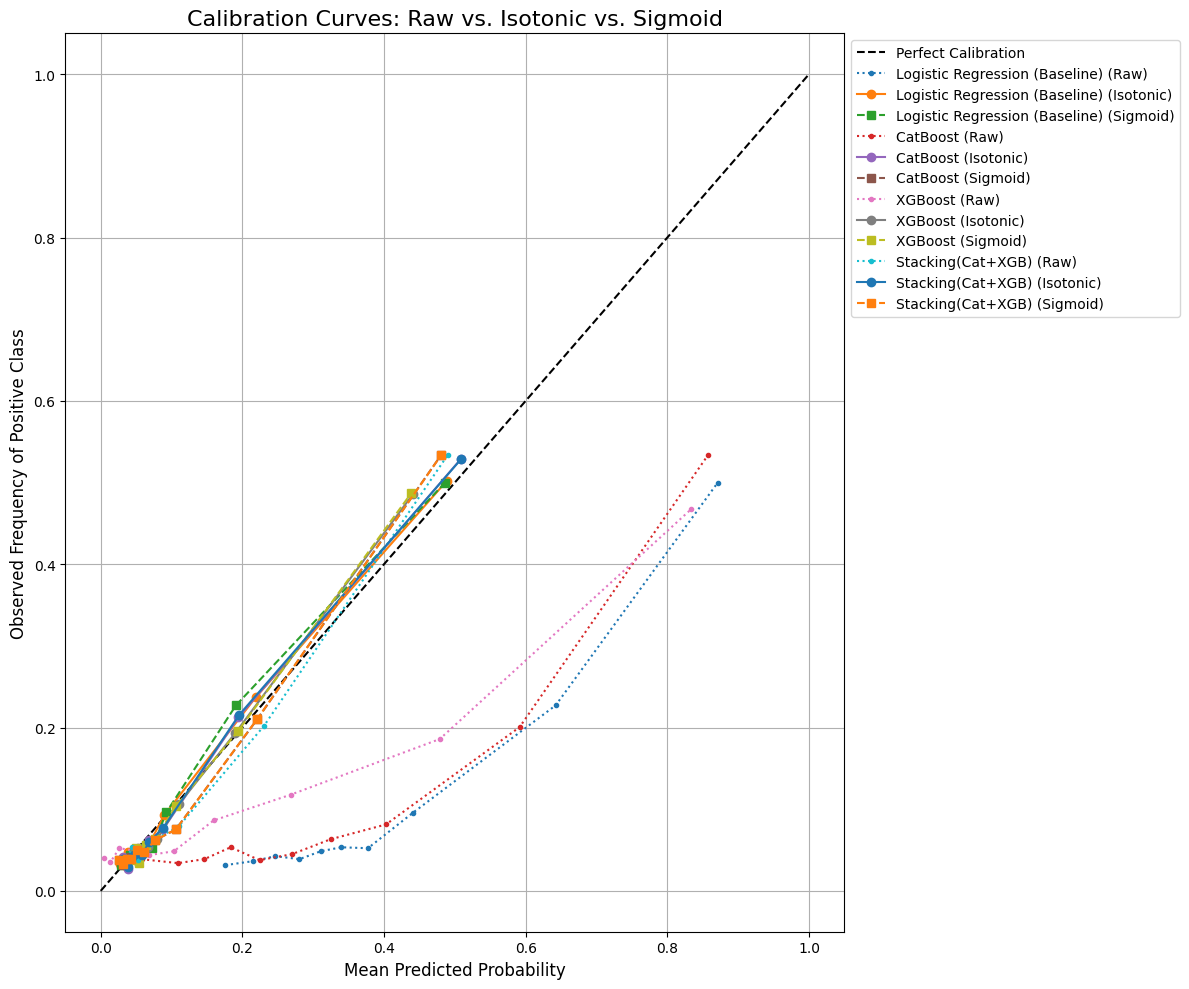

In [16]:


# ============================================================
# 6) Compare calibration curves for all models and methods
# ------------------------------------------------------------

plt.figure(figsize=(12, 10))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

# Plot calibration curves for all models and versions
for r in results:
    # Raw
    frac_pos_raw, mean_pred_raw = calibration_curve(y_test, r['proba_raw'], n_bins=10, strategy='quantile')
    plt.plot(mean_pred_raw, frac_pos_raw, marker='.', linestyle=':', label=f"{r['name']} (Raw)")

    # Isotonic
    frac_pos_iso, mean_pred_iso = calibration_curve(y_test, r['proba_iso'], n_bins=10, strategy='quantile')
    plt.plot(mean_pred_iso, frac_pos_iso, marker='o', linestyle='-', label=f"{r['name']} (Isotonic)")

    # Sigmoid (optional to plot, but good for completeness)
    frac_pos_sig, mean_pred_sig = calibration_curve(y_test, r['proba_sig'], n_bins=10, strategy='quantile')
    plt.plot(mean_pred_sig, frac_pos_sig, marker='s', linestyle='--', label=f"{r['name']} (Sigmoid)")

plt.title("Calibration Curves: Raw vs. Isotonic vs. Sigmoid", fontsize=16)
plt.xlabel("Mean Predicted Probability", fontsize=12)
plt.ylabel("Observed Frequency of Positive Class", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Move legend outside plot
plt.grid(True)
plt.tight_layout()
plt.show()



# Pick the best overall calibrated model by the lowest Isotonic Brier score
best_model_result = min(results, key=lambda d: d['brier_iso'])

# Prepare the 'best' dictionary for use in section 8
best = {
    'name': best_model_result['name'],
    'proba_cal': best_model_result['proba_iso'],
    'brier_cal': best_model_result['brier_iso']
}

In [17]:
# =========================================================================
# 6.1) Calculate Calibration Slope & Intercept for the Champion Model
# =========================================================================
from scipy.special import logit
from sklearn.linear_model import LogisticRegression
import numpy as np

# Get the calibrated probabilities of the best model
y_pred_calibrated = best['proba_cal'].copy()

# Clip probabilities to avoid logit(0) or logit(1) which are undefined (-inf, +inf)
eps = 1e-15
y_pred_calibrated = np.clip(y_pred_calibrated, eps, 1 - eps)

# Transform probabilities to logit scale
logit_transformed_predictions = logit(y_pred_calibrated).reshape(-1, 1)

# Fit a logistic regression model: y_true ~ logit(y_pred_calibrated)
# The coefficient of this model is the calibration slope
# The intercept of this model is the calibration intercept
cal_model = LogisticRegression(solver='lbfgs')
cal_model.fit(logit_transformed_predictions, y_test.values)

# Extract slope and intercept
slope = cal_model.coef_[0][0]
intercept = cal_model.intercept_[0]

print(f"\n--- Calibration Diagnostics for Champion Model: {best['name']} (Isotonic) ---")
print(f"  Calibration Slope     = {slope:.3f}")
print(f"  Calibration Intercept = {intercept:.3f}")
print("  (Ideal values are Slope ≈ 1.0 and Intercept ≈ 0.0)")


--- Calibration Diagnostics for Champion Model: Stacking(Cat+XGB) (Isotonic) ---
  Calibration Slope     = 1.066
  Calibration Intercept = 0.104
  (Ideal values are Slope ≈ 1.0 and Intercept ≈ 0.0)


In [18]:
import numpy as np
from scipy.special import logit

p = best['proba_cal'].copy()
y_true = y_test.values
eps = 1e-6
p = np.clip(p, eps, 1-eps)

mean_p = float(p.mean())
mean_y = float(y_true.mean())
citl = logit(mean_y) - logit(mean_p)  # calibration-in-the-large
print(f"mean(pred)={mean_p:.4f} | mean(y)={mean_y:.4f} | CITL={citl:.3f}")


mean(pred)=0.1133 | mean(y)=0.1127 | CITL=-0.006


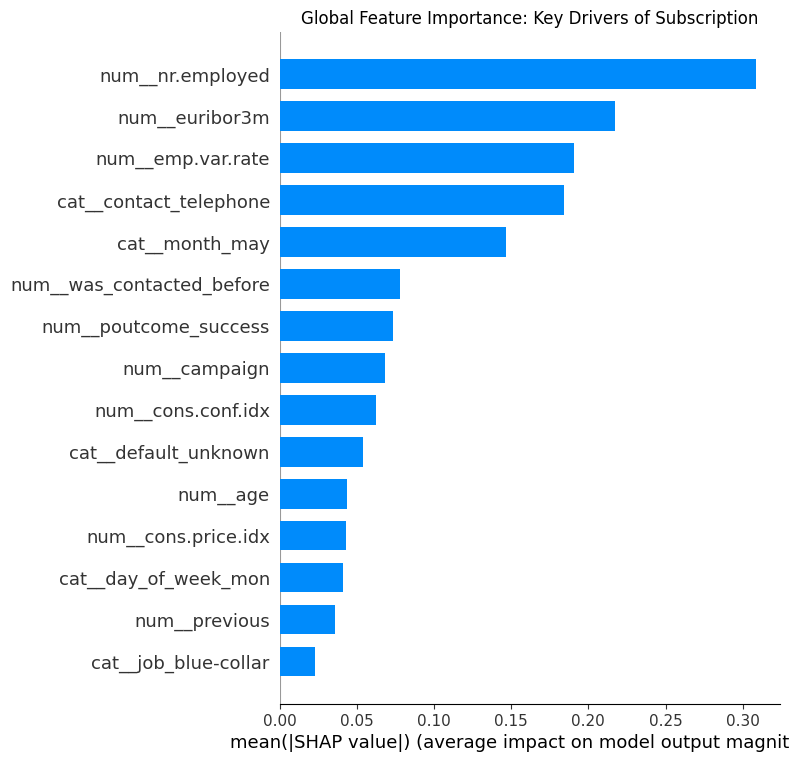

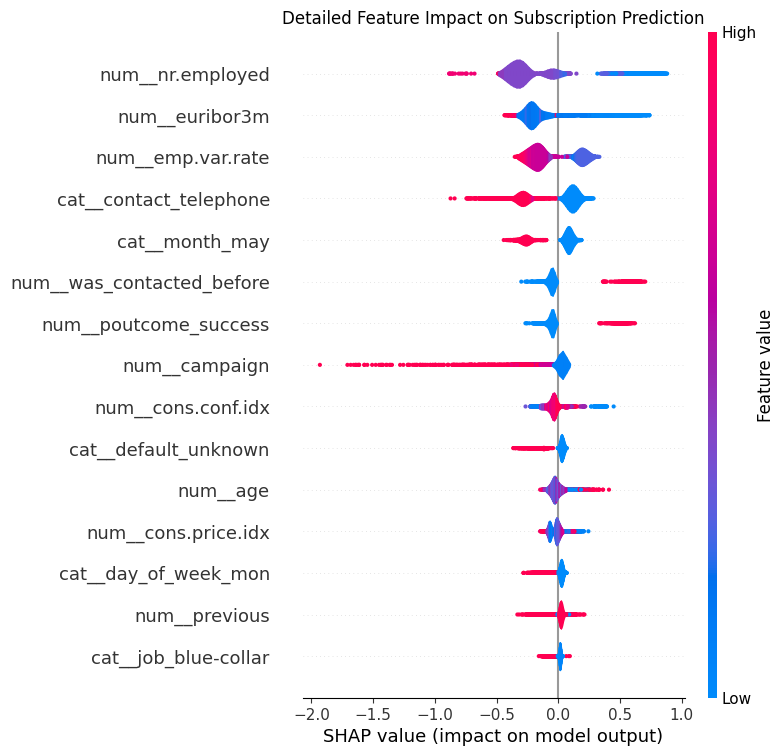

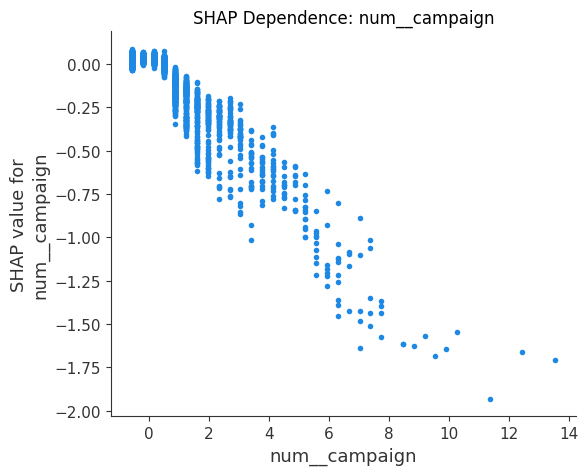

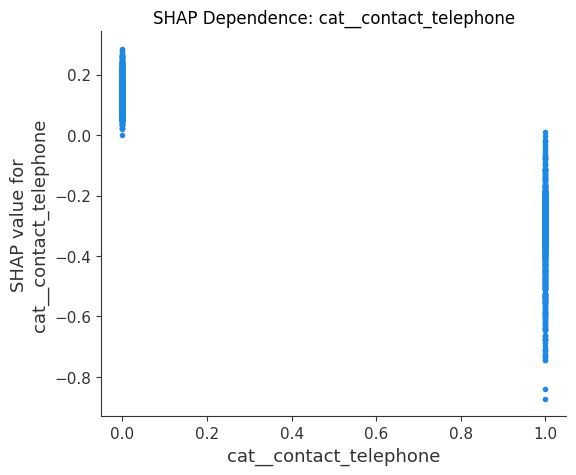

In [19]:
# 7) SHAP on raw CatBoost (interpretability)
# ------------------------------------------------------------
cat_raw_for_shap = CatBoostClassifier(
    iterations=1200, depth=8, learning_rate=0.03,
    loss_function='Logloss', eval_metric='AUC',
    class_weights=[1.0, pos_weight], random_state=RANDOM_STATE, verbose=0
).fit(X_train_proc, y_train, eval_set=(X_test_proc, y_test), use_best_model=True)

explainer = shap.TreeExplainer(cat_raw_for_shap)
shap_values = explainer.shap_values(X_test_proc)
X_test_df = pd.DataFrame(X_test_proc, columns=feature_names)

shap.summary_plot(shap_values, X_test_df, plot_type='bar', show=False, max_display=15)
plt.title('Global Feature Importance: Key Drivers of Subscription'); plt.show()

shap.summary_plot(shap_values, X_test_df, plot_type='violin', show=False, max_display=15)
plt.title('Detailed Feature Impact on Subscription Prediction'); plt.show()

for fname in ['num__campaign', 'cat__contact_telephone']:
    if fname in X_test_df.columns:
        shap.dependence_plot(fname, shap_values, X_test_df,
                             interaction_index=None, show=False)
        plt.title(f"SHAP Dependence: {fname}"); plt.show()


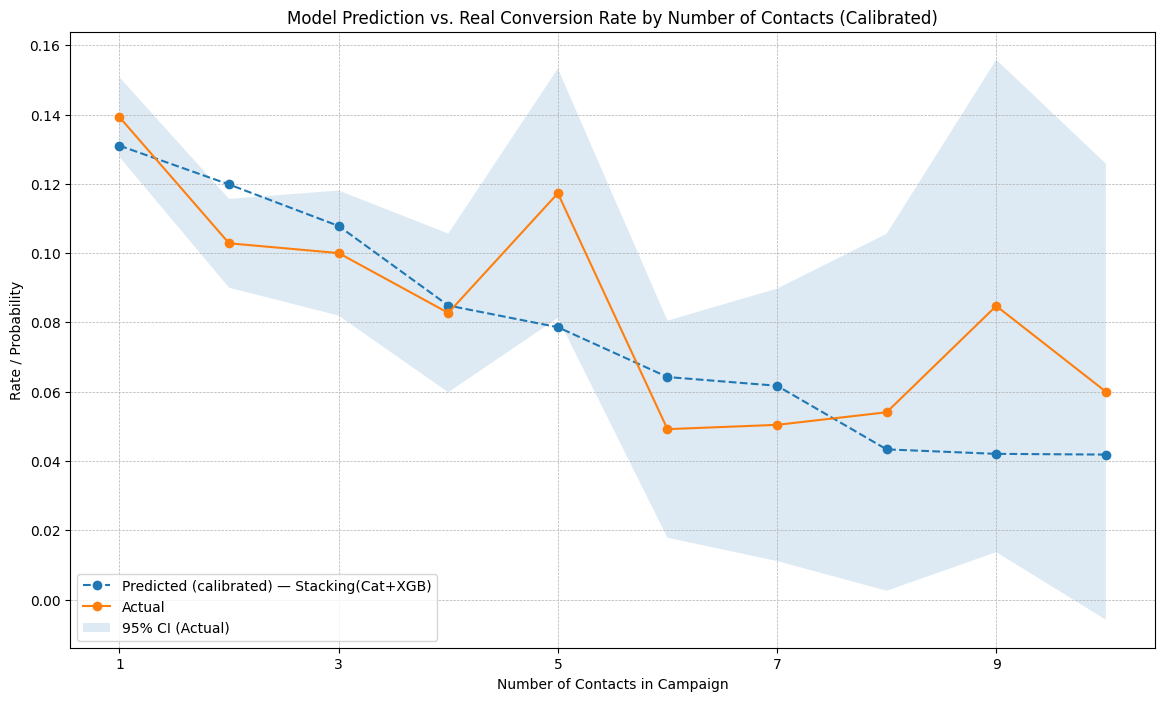


Summary table (using best calibrated model):
 campaign  customer_count  actual_conversion_rate  avg_predicted_probability
        1            3476                0.139241                   0.131013
        2            2159                0.102825                   0.119808
        3            1060                0.100000                   0.107820
        4             556                0.082734                   0.084863
        5             307                0.117264                   0.078608
        6             183                0.049180                   0.064225
        7             119                0.050420                   0.061704
        8              74                0.054054                   0.043340
        9              59                0.084746                   0.042047
       10              50                0.060000                   0.041838


In [33]:
# 8) Final business plot using the *selected* calibrated model
# ------------------------------------------------------------
# compute calibrated probabilities from the winning calibrated model
proba_best_cal = best['proba_cal']   # already on TEST

res_cal = pd.DataFrame({
    'y_true': y_test.values,
    'campaign': X_test['campaign'].values,
    'pred': proba_best_cal
})
g = res_cal.groupby('campaign').agg(
    customer_count=('y_true','size'),
    actual_conversion_rate=('y_true','mean'),
    avg_predicted_probability=('pred','mean')
).reset_index().sort_values('campaign')
g = g[g['customer_count'] >= 50]  # stability

z = 1.96
g['moe'] = z*np.sqrt((g['actual_conversion_rate']*(1-g['actual_conversion_rate']))/g['customer_count'])
g['ci_lower'] = g['actual_conversion_rate'] - g['moe']
g['ci_upper'] = g['actual_conversion_rate'] + g['moe']

plt.figure(figsize=(14,8))
plt.plot(g['campaign'], g['avg_predicted_probability'], 'o--', label=f"Predicted (calibrated) — {best['name']}")
plt.plot(g['campaign'], g['actual_conversion_rate'], 'o-', label='Actual')
plt.fill_between(g['campaign'], g['ci_lower'], g['ci_upper'], alpha=0.15, label='95% CI (Actual)')
plt.title('Model Prediction vs. Real Conversion Rate by Number of Contacts (Calibrated)')
plt.xlabel('Number of Contacts in Campaign'); plt.ylabel('Rate / Probability')
plt.xticks(np.arange(g['campaign'].min(), g['campaign'].max()+1, 2))
plt.grid(True, linestyle='--', linewidth=0.5); plt.legend(); plt.show()

print("\nSummary table (using best calibrated model):")
print(g[['campaign','customer_count','actual_conversion_rate','avg_predicted_probability']].to_string(index=False))


In [34]:
# Statistical test for difference in conversion rates (≤3 vs >3 contacts)
import scipy.stats as stats
import numpy as np

group_le3 = res_cal.loc[res_cal['campaign'] <= 3, 'y_true']
group_gt3 = res_cal.loc[res_cal['campaign'] > 3, 'y_true']

success_le3 = group_le3.sum(); n_le3 = group_le3.size
success_gt3 = group_gt3.sum(); n_gt3 = group_gt3.size

p1 = success_le3 / n_le3
p2 = success_gt3 / n_gt3

p_pool = (success_le3 + success_gt3) / (n_le3 + n_gt3)
z = (p1 - p2) / np.sqrt(p_pool * (1 - p_pool) * (1/n_le3 + 1/n_gt3))
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Conversion rate ≤3 contacts: {p1:.3f}")
print(f"Conversion rate >3 contacts: {p2:.3f}")
print(f'Z = {z:.2f}, p-value = {p_value:.4f}')


Conversion rate ≤3 contacts: 0.121
Conversion rate >3 contacts: 0.075
Z = 5.15, p-value = 0.0000


In [36]:


# --- 9.results DataFrame with predictions and original features ---
results_df_subgroup = X_test.copy()
results_df_subgroup['y_true'] = y_test.values
results_df_subgroup['proba_calibrated'] = best['proba_cal'] # Using the champion model's probabilities

# ---  Define Age Groups ---
# Create age bins based on common demographic splits
bins = [17, 29, 39, 49, 59, 99]
labels = ['17-29 (Young)', '30-39 (Adult)', '40-49 (Mid-Age)', '50-59 (Senior)', '60+ (Elder)']
results_df_subgroup['age_group'] = pd.cut(results_df_subgroup['age'], bins=bins, labels=labels, right=True)

# ---  Function to calculate metrics (we already have this for slope/intercept) ---
def calculate_slope_intercept(y_true, y_pred_proba):
    eps = 1e-15
    p = np.clip(y_pred_proba, eps, 1 - eps)
    logit_p = logit(p).reshape(-1, 1)

    # Handle cases where a subgroup might have only one class
    if len(np.unique(y_true)) < 2:
        return np.nan, np.nan

    lr = LogisticRegression(solver='lbfgs')
    lr.fit(logit_p, y_true)
    return lr.coef_[0][0], lr.intercept_[0]

# ---  Loop through each group, calculate metrics, and store them ---
subgroup_metrics = []

for group_name, group_df in results_df_subgroup.groupby('age_group'):
    # Ensure there are enough samples and both classes are present
    if len(group_df) < 50 or len(group_df['y_true'].unique()) < 2:
        continue

    y_true_group = group_df['y_true']
    proba_cal_group = group_df['proba_calibrated']

    brier = brier_score_loss(y_true_group, proba_cal_group)
    slope, intercept = calculate_slope_intercept(y_true_group.values, proba_cal_group.values)

    subgroup_metrics.append({
        'Subgroup': group_name,
        'N': len(group_df),
        'Brier Score': brier,
        'Calib. Slope': slope,
        'Calib. Intercept': intercept
    })

# ---  Create and print the final results table ---
subgroup_table = pd.DataFrame(subgroup_metrics)

print("--- Subgroup Calibration Metrics (by Age Group) ---")
# Format the table for better readability
print(subgroup_table.to_string(index=False, formatters={
    'Brier Score': '{:.4f}'.format,
    'Calib. Slope': '{:.3f}'.format,
    'Calib. Intercept': '{:.3f}'.format
}))

--- Subgroup Calibration Metrics (by Age Group) ---
       Subgroup    N Brier Score Calib. Slope Calib. Intercept
  17-29 (Young) 1077      0.0953        1.085           -0.005
  30-39 (Adult) 3426      0.0791        1.079            0.266
40-49 (Mid-Age) 2097      0.0557        1.126            0.100
 50-59 (Senior) 1421      0.0639        1.002           -0.125
    60+ (Elder)  215      0.1993        0.784            0.084
